# Welcome to Sawyer's ROS2 Playground

ROS (robotic operating system) is a protocol that allows you to talk to many different types of robots. https://docs.ros.org/en/rolling/Tutorials.html has more than you ever wanted to know about ROS.



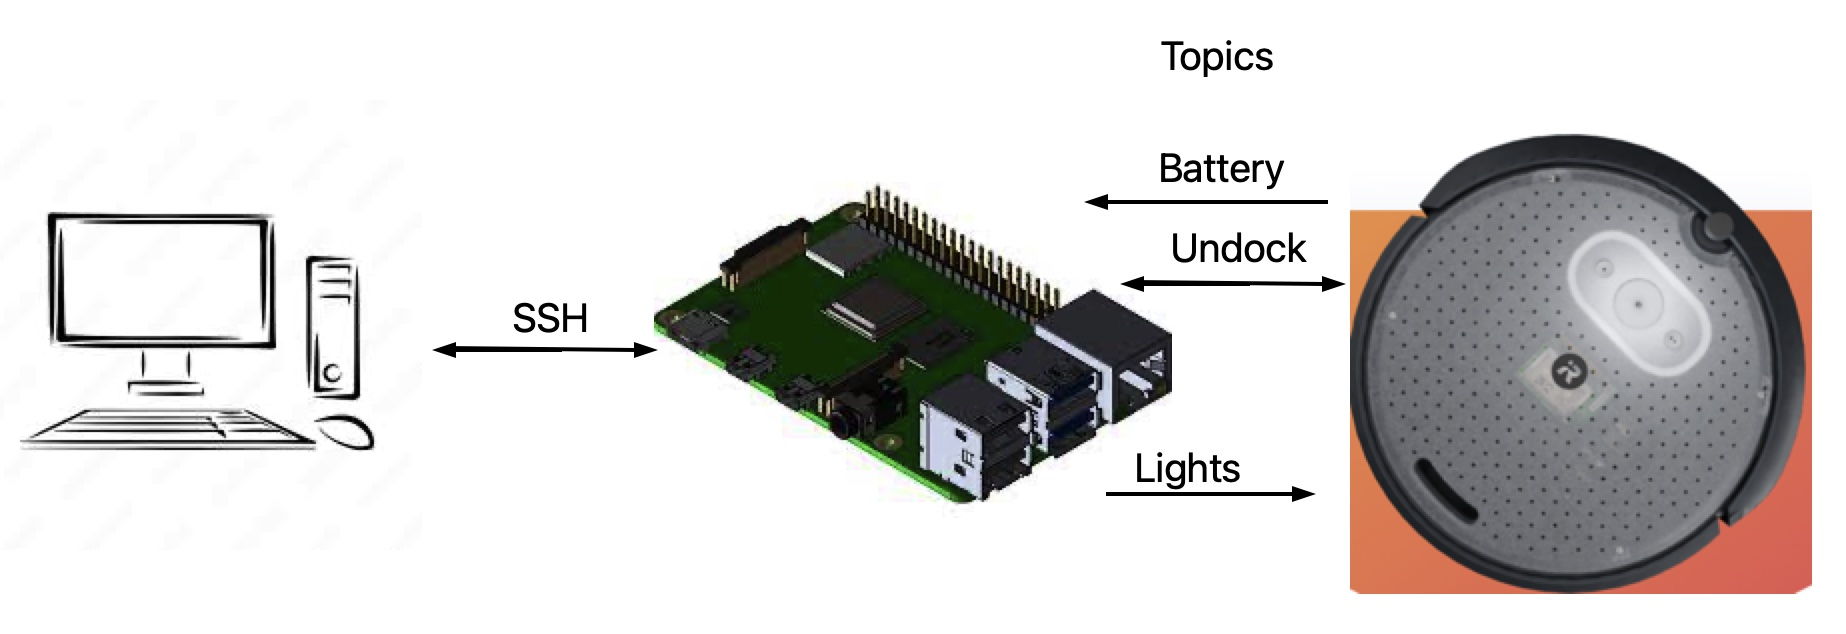

You will SSH into the Raspberry Pi - and then make various calls to the Create in the form of ROS topics.  Once you SSH in - try typing 

In [ ]:
ros2 topic list

Below is python code that will let you make stuff happen - try it out and see what happens.

In the future all sorts of shortcuts will be here - starting with something like "from Sawyer import LED" and away you will go

# iRobot Create3 Python Code Snippets

Outline
1. Subscribing to a Specific Topic (Battery State)
2. Publishing to a Specific Topic (LED Color)
3. Sending Action to Server (Undocking/Docking Robot)
4. Making the Robot Move 
5. Making the Robot Turn

In [ ]:
import os

os.system("export RMW_IMPLEMENTATION=rmw_fastrtps_cpp")
os.system("export FASTRTPS_DEFAULT_PROFILES_FILE=/home/ubuntu/unicast.xml") # Unicast.xml needs to be changed for each Create3

os.system("pkill -9 _ros2_daemon")
os.system("ros2 topic list --no-daemon --spin-time 10")

## Subscribing to a Topic

### Undocking the Create
```console
ubuntu@ubuntu:~$ ros2 topic echo /battery_state
```

In [ ]:
import sys,rclpy
from rclpy.node import Node
from rclpy.qos import qos_profile_sensor_data

from sensor_msgs.msg import BatteryState

class BatterySubscriber(Node):
    def __init__(self):
        super().__init__('batter_subscriber')
        self.subscription = self.create_subscription(
            BatteryState,'/battery_state',self.listener_callback,qos_profile_sensor_data)        
        self.subscription  # prevent unused variable warning

    def listener_callback(self, msg):
        self.get_logger().info('I heard: "%s"' % msg)


def main(args=None):
    rclpy.init(args=args)

    batter_subscriber = BatterySubscriber()
    try: 
        rclpy.spin(batter_subscriber)
    except KeyboardInterrupt:
        print('Caught keyboard interrupt')
    except BaseException:
        print('Exception:', file=sys.stderr)
    finally:
        batter_subscriber.destroy_node()
        rclpy.shutdown()

if __name__ == '__main__':
    main()

## Publishing to a Topic

### Undocking the Create
```console
ubuntu@ubuntu:~$ ros2 topic pub 
```

In [ ]:
import rclpy
from rclpy.node import Node

from std_msgs.msg import String
from irobot_create_msgs.msg import LedColor
from irobot_create_msgs.msg import LightringLeds

class ColorPalette():
    """ Helper Class to define frequently used colors"""
    def __init__(self):
        self.red = LedColor(red=255,green=0,blue=0)
        self.green = LedColor(red=0,green=255,blue=0)
        self.blue = LedColor(red=0,green=0,blue=255)
        self.yellow = LedColor(red=255,green=255,blue=0)
        self.pink = LedColor(red=255,green=0,blue=255)
        self.cyan = LedColor(red=0,green=255,blue=255)
        self.purple = LedColor(red=127,green=0,blue=255)
        self.white = LedColor(red=255,green=255,blue=255)
        self.grey = LedColor(red=189,green=189,blue=189)

class Lights():
    """ Class to tell the robot to set lightring lights as part of dance sequence"""
    def __init__(self, led_colors):
        """
        Parameters
        ----------
        led_colors : list of LedColor
            The list of 6 LedColors corresponding to the 6 LED lights on the lightring
        """
        self.led_colors = led_colors

class LEDPublisher(Node):

    def __init__(self):
        super().__init__('led_publisher')
        self.cp = ColorPalette()
        self.lights_publisher = self.create_publisher(LightringLeds, 'cmd_lightring', 10)
        timer_period = 0.5  # seconds
        self.timer = self.create_timer(timer_period, self.timer_callback)

    def timer_callback(self):
        current_time = self.get_clock().now()
        test = Lights([self.cp.red, self.cp.green, self.cp.grey, self.cp.green, self.cp.grey, self.cp.green]) ## NOTE Can get ride of Lights Object definition.
        lightring = LightringLeds()
        lightring.override_system = True
        lightring.leds = test.led_colors

        self.get_logger().info('Time %f New lights action, first led (%d,%d,%d)' % (current_time.nanoseconds / float(1e9), lightring.leds[0].red, lightring.leds[0].green, lightring.leds[0].blue))

        lightring.header.stamp = current_time.to_msg()

        self.lights_publisher.publish(lightring)


def main(args=None):
    rclpy.init(args=args)

    led_publisher = LEDPublisher()

    rclpy.spin(led_publisher)

    # Destroy the node explicitly
    # (optional - otherwise it will be done automatically
    # when the garbage collector destroys the node object)
    led_publisher.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()

## Sending an Action to the Server

### Undocking the Create
```console
ubuntu@ubuntu:~$ ros2 action send_goal /undock irobot_create_msgs/action/Undock "{}"
```

In [ ]:
import rclpy
from rclpy.action import ActionClient
from rclpy.node import Node

from irobot_create_msgs.action import Undock


class UndockingActionClient(Node):

    def __init__(self):
        super().__init__('undocking_action_client')
        self._action_client = ActionClient(self, Undock, 'undock')

    def send_goal(self, order):
        goal_msg = Undock.Goal()
        print(goal_msg)

        self._action_client.wait_for_server()

        self._send_goal_future = self._action_client.send_goal_async(goal_msg)

        self._send_goal_future.add_done_callback(self.goal_response_callback)

    def goal_response_callback(self, future):
        goal_handle = future.result()
        if not goal_handle.accepted:
            self.get_logger().info('Goal rejected :(')
            return

        self.get_logger().info('Goal accepted :)')

        self._get_result_future = goal_handle.get_result_async()
        self._get_result_future.add_done_callback(self.get_result_callback)

    def get_result_callback(self, future):
        result = future.result().result
        self.get_logger().info('Result: {0}'.format(result))
        rclpy.shutdown()


def main(args=None):
    rclpy.init(args=args)

    action_client = UndockingActionClient()

    action_client.send_goal("{}")

    rclpy.spin(action_client)


if __name__ == '__main__':
    main()

### Docking the Create 

```console
ubuntu@ubuntu:~$ ros2 action send_goal /dock irobot_create_msgs/action/DockServo "{}"
```

In [ ]:
import rclpy
from rclpy.action import ActionClient
from rclpy.node import Node

from irobot_create_msgs.action import DockServo

class DockServoActionClient(Node):
    '''
    Code to dock the Create3
    Equivalent Command Line Call: ros2 action send_goal /dock irobot_create_msgs/action/DockServo "{}"
    '''
    def __init__(self):
        super().__init__('dockservo_action_client')
        self._action_client = ActionClient(self, DockServo, 'dock')

    def send_goal(self, order):
        goal_msg = DockServo.Goal()

        self._action_client.wait_for_server()
        self._send_goal_future = self._action_client.send_goal_async(goal_msg)
        self._send_goal_future.add_done_callback(self.goal_response_callback)

    def goal_response_callback(self, future):
        goal_handle = future.result()
        if not goal_handle.accepted:
            self.get_logger().info('Goal rejected :(')
            return

        self.get_logger().info('Goal accepted :)')

        self._get_result_future = goal_handle.get_result_async()
        self._get_result_future.add_done_callback(self.get_result_callback)

    def get_result_callback(self, future):
        result = future.result().result
        self.get_logger().info('Result: {0}'.format(result))
        rclpy.shutdown()


def main(args=None):
    rclpy.init(args=args)

    action_client = DockServoActionClient()

    action_client.send_goal("{}")

    rclpy.spin(action_client)


if __name__ == '__main__':
    main()

### Rotate the Create3

```console
ubuntu@ubuntu:~$ ros2 action send_goal /rotate_angle irobot_create_msgs/action/RotateAngle "{"angle": 1.57, "max_rotation_speed": 0.5}"
```

In [ ]:
import rclpy
from rclpy.action import ActionClient
from rclpy.node import Node

from irobot_create_msgs.action import RotateAngle

class RotateActionClient(Node):

    def __init__(self):
        super().__init__('rotate_action_client')
        self._action_client = ActionClient(self, RotateAngle, 'rotate_angle')

    def send_goal(self, angle=1.57, max_rotation_speed=0.5):
        goal_msg = RotateAngle.Goal()
        goal_msg.angle = angle 
        goal_msg.max_rotation_speed = max_rotation_speed

        self._action_client.wait_for_server()

        self._send_goal_future = self._action_client.send_goal_async(goal_msg)

        self._send_goal_future.add_done_callback(self.goal_response_callback)

    def goal_response_callback(self, future):
        goal_handle = future.result()
        if not goal_handle.accepted:
            self.get_logger().info('Goal rejected :(')
            return

        self.get_logger().info('Goal accepted :)')

        self._get_result_future = goal_handle.get_result_async()
        self._get_result_future.add_done_callback(self.get_result_callback)

    def get_result_callback(self, future):
        result = future.result().result
        self.get_logger().info('Result: {0}'.format(result))
        rclpy.shutdown()


def main(args=None):
    rclpy.init(args=args)

    action_client = RotateActionClient()

    angle = 1.57
    speed = 0.5 # Max 1.9

    action_client.send_goal(angle, speed)
    rclpy.spin(action_client)


if __name__ == '__main__':
    main()

### Drive Distance Forward

```console
ubuntu@ubuntu:~$ ros2 action send_goal /drive_distance irobot_create_msgs/action/DriveDistance "{"distance": 0.5, "max_translation_speed": 0.15}"
```

In [ ]:
import rclpy
from rclpy.action import ActionClient
from rclpy.node import Node

from irobot_create_msgs.action import DriveDistance

class DriveDistanceActionClient(Node):

    def __init__(self):
        super().__init__('drive_distance_action_client')
        self._action_client = ActionClient(self, DriveDistance, 'drive_distance')

    def send_goal(self, distance=0.5, max_translation_speed=0.15):
        goal_msg = DriveDistance.Goal()
        goal_msg.distance = distance 
        goal_msg.max_translation_speed = max_translation_speed

        self._action_client.wait_for_server()

        self._send_goal_future = self._action_client.send_goal_async(goal_msg)

        self._send_goal_future.add_done_callback(self.goal_response_callback)

    def goal_response_callback(self, future):
        goal_handle = future.result()
        if not goal_handle.accepted:
            self.get_logger().info('Goal rejected :(')
            return

        self.get_logger().info('Goal accepted :)')

        self._get_result_future = goal_handle.get_result_async()
        self._get_result_future.add_done_callback(self.get_result_callback)

    def get_result_callback(self, future):
        result = future.result().result
        self.get_logger().info('Result: {0}'.format(result))
        rclpy.shutdown()


def main(args=None):
    rclpy.init(args=args)

    action_client = DriveDistanceActionClient()

    dist = 0.5
    speed = 0.15 

    action_client.send_goal(dist, speed)
    rclpy.spin(action_client)


if __name__ == '__main__':
    main()